**Zadanie 1**  
Uruchom przykład Incremental learning z punktu 2.1 dobierając parametry tak, aby ilość danych do przeliczenia była większa niż sumaryczna ilość pamięci RAM workerów. Obserwuj daszboard i w razie niepowodzenia dostosuj wielkość i ilość chunków tak, aby obliczenia się wykonały na tych samych parametrach workerów. Zobacz jak wygląda struktura pamięci na workerach, czy nie dochodzi do zrzucania pamięci na dysk (zapewne będzie on wąskim gardłem, więc w menedżerze będzie widać jego mocne obciążenie). Zastanów się czy można to jakoś zoptymalizować przy dostępnych workerach i wykonaj kilka eksperymentów szukając większej wydajności i krótszego czasu wykonania całego zadania.

In [1]:
from dask.distributed import Client

client = Client(n_workers=6, threads_per_worker=2, memory_limit="4GB")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 12,Total memory: 22.35 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:63712,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 22.35 GiB
Comm: tcp://127.0.0.1:63744,Total threads: 2
Dashboard: http://127.0.0.1:63755/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:63715,


In [2]:
import dask
import dask.array as da
from dask_ml.datasets import make_classification
from dask_ml.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from dask_ml.wrappers import Incremental

n, d = 10000000, 500
X, y = make_classification(n_samples=n, n_features=d,
                           chunks=n // 128, flip_y=0.2)
display(X)

C:\Users\Arek\PycharmProjects\BDA\.venv\Lib\site-packages\dask\base.py:1101: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


dask.array<normal, shape=(10000000, 500), dtype=float64, chunksize=(78125, 500), chunktype=numpy.ndarray>

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
display(X_train)

classes = da.unique(y_train).compute()

est = SGDClassifier(loss='log_loss', penalty='l2', tol=1e-3)
inc = Incremental(est, scoring='accuracy')

inc.fit(X_train, y_train, classes=classes)
print(f'Model accuracy: {inc.score(X_test, y_test)}')

dask.array<concatenate, shape=(8999936, 500), dtype=float64, chunksize=(70312, 500), chunktype=numpy.ndarray>

Model accuracy: 0.6320035517726865


### Przy takich parametrach zrzuca trochę pamięci na dysk, ale całość wykonuje się w czasie 1 minuty i 5 sekund - najlepszy jaki udało mi się uzyskać.

**Zadanie 2**  
Dokonaj serializacji modelu z zadania 1 na dysk i następnie go wczytaj ponownie tak, aby można było uruchomić na nim predykcję dla tablic X_test oraz y_test (dla użycia miar klasyfikacji) i wyświetl macierz klasyfikacji (confusion matrix).

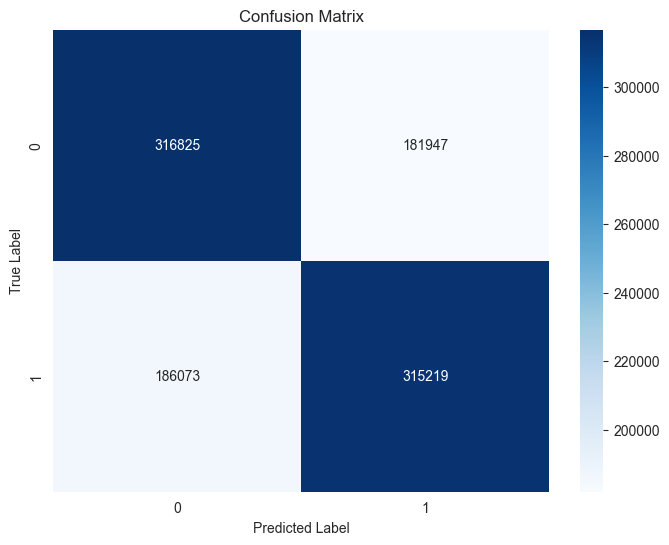

In [4]:
import joblib
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

joblib.dump(inc, 'data/incremental_model.joblib')
loaded_model = joblib.load('data/incremental_model.joblib')

y_pred = loaded_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**Zadanie 3**  
Korzystając z danych stworzonych w zadaniu 1 uruchom poszukiwanie optymalnych parametrów modelu tak jak zostało to zaprezentowane w przykładzie 5. Ta metoda powinna sama wybierać modele obiecujące i trenować je na większej liczbie danych porzucając jednocześnie modele, które nie rokują.
Sprawdź jak wyglądają najlepsze wyliczone parametry vs. te użyte w zadaniu 1 i ewentualnie dopasuj próbkę danych jeżeli jej inicjalna wielkość nie pozwala na wykonanie zadania (zwróć uwagę na ilość i wielkość chunków w przykładzie 3 oraz 5, w tym drugim jest ich znacznie więcej, co przyspiesza poszukiwanie optymalnych parametrów).

In [5]:
from dask_ml.model_selection import IncrementalSearchCV
from sklearn.linear_model import SGDClassifier
import numpy as np


model = SGDClassifier(tol=1e-3, penalty='elasticnet', random_state=0)

params = {
    'alpha': np.logspace(-2, 1, num=1000),
    'l1_ratio': np.linspace(0, 1, num=1000),
    'average': [True, False]
}

search = IncrementalSearchCV(
    model,
    params,
    random_state=0,
    n_initial_parameters=1000,
    patience=20,
    max_iter=100
)
search.fit(X, y, classes=[0, 1])

print(f"Best Score: {search.best_score_}")
print(f"Best Parameters: {search.best_params_}")

C:\Users\Arek\PycharmProjects\BDA\.venv\Lib\site-packages\dask_ml\model_selection\_incremental.py:1039: FutureWarning: decay_rate has been deprecated since Dask-ML v1.4.0.

    * Use InverseDecaySearchCV to use `decay_rate`
    * Specify decay_rate=None


  warn(


Best Score: 0.659676759410802
Best Parameters: {'l1_ratio': np.float64(0.9139139139139139), 'average': False, 'alpha': np.float64(0.01)}


In [6]:
client.close()